# 25/10/08 Visualisation and analysis of FANS count data.

In this notebook, we will work on the long-format data frame generated in `SortStatsFromPDFSortReports.ipynb`. It combines the meta-data, recorded by hand during sample processing, with the count data obtained post-sorting. 

To do:
- explore the data with a variety of plots and summary statistics
- perform inferential analysis on the variables driving cell number differences between groups.

In [1]:
from pathlib import Path
import pandas as pd
import itertools
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
# Make pandas display floats nicely without affecting underlying data
pd.set_option("display.float_format", "{:,.2f}".format)

In [3]:
# load in the tidied, long-format FANS data
df_path = Path("~/phd_work/experiment_383/exp_383_flowCytometry_analysis/tidied_FANS_data/exp383_tidy_FANS_data_long.csv")
df = pd.read_csv(df_path)
df.tail()

,animal_id,group_no,inoculum,inoculation_batch,dpi,sample_mass_mg,date_nuc_prep,incubation_time_hrs,population,count_statistic,count_value
571,918318,4,CBH,BATCH4,60,221,2025-08-19,19.48,SOX2+,EstTotalCount_per_mg,689.16
572,917440,4,CBH,BATCH3,60,254,2025-08-20,18.80,SOX2+,EstTotalCount_per_mg,"1,031.31"
573,916468,19,22L,BATCH1,120,243,2025-08-20,19.43,SOX2+,EstTotalCount_per_mg,707.20
574,917445,3,22L,BATCH3,60,294,2025-08-21,22.62,SOX2+,EstTotalCount_per_mg,"1,220.23"
575,918278,17,RML,BATCH4,120,215,2025-08-21,18.08,SOX2+,EstTotalCount_per_mg,812.52


In [4]:
populationStats = (
    df.groupby(["population", "count_statistic"])["count_value"]
        .agg(["count", "mean", "std", "min", "max"])
        .sort_values(by=["count_statistic", "population"])
        .reset_index()
)
#populationStats

In [5]:
# generate summary stats for each experimental group
groupStats = (
    df.groupby(["dpi", "inoculum","population", "count_statistic"])["count_value"]
        .agg(["count", "mean", "std", "min", "max"])
        .sort_values(by=["count_statistic", "population"])
        .reset_index()
)

csvpath = Path("~/phd_work/experiment_383/exp_383_flowCytometry_analysis/tidied_FANS_data/FANS_population_counts_by_group.csv")
groupStats.to_csv(csvpath)
#groupStats

In [6]:
# specify an order to the factors columns
dpi_order = [60, 90, 120]
inoc_order = ['CBH', 'RML', 'ME7', '22L']
pop_order = ['NeuN+', 'PU1+', 'SOX10+', 'SOX2+']

In [7]:
# encode necessary cols as ordered categorical variables
df['dpi'] = pd.Categorical(df['dpi'], categories = dpi_order, ordered=True )
df['inoculum'] = pd.Categorical(df['inoculum'], categories = inoc_order, ordered=True )
df['population'] = pd.Categorical(df['population'], categories = pop_order, ordered=True )

In [8]:
# we will work with the raw counts only first (not mass-normalized)
df_raw = df[df['count_statistic'] == 'EstTotalCount'].copy()
df_norm = df[df['count_statistic'] == 'EstTotalCount_per_mg'].copy()

In [9]:
# We want to add a column that provides a descriptor of experimental groups
# e.g. 60_dpi_RML
def add_group_label(df, inplace=False):
    """
    Add a 'group_label' column combining dpi, inoculum, and population.
    """
    # Decide whether to modify in place or return a copy
    target = df if inplace==True else df.copy()

    target['group_label'] = (
        target['dpi'].astype(str) + '_dpi_' +
        target['inoculum'].astype(str) + '_' +
        target['population'].astype(str)
    )

    return target

df_raw = add_group_label(df_raw, inplace=True)
df_norm = add_group_label(df_norm, inplace=True)

In [10]:
# make a list containing group_label values in desired order
ordered_groups = [
    f'{d}_dpi_{i}_{p}'
    for d, i, p, in itertools.product(dpi_order, inoc_order, pop_order)
]
#check format
ordered_groups[0:4]

['60_dpi_CBH_NeuN+',
 '60_dpi_CBH_PU1+',
 '60_dpi_CBH_SOX10+',
 '60_dpi_CBH_SOX2+']

In [11]:
def order_fac_levels(df_col, order_list):
    """
    Takes a data frame column and a list of the levels of a factor
    Returns: column as a Categorical with factors ordered per order_list
    """
    ord_col = pd.Categorical(df_col,
                            categories = order_list,
                            ordered=True)
    return ord_col

# set the order
df_raw['group_label'] = order_fac_levels(
    df_raw['group_label'],
    order_list=ordered_groups
)
df_norm['group_label'] = order_fac_levels(
    df_raw['group_label'],
    order_list=ordered_groups
)

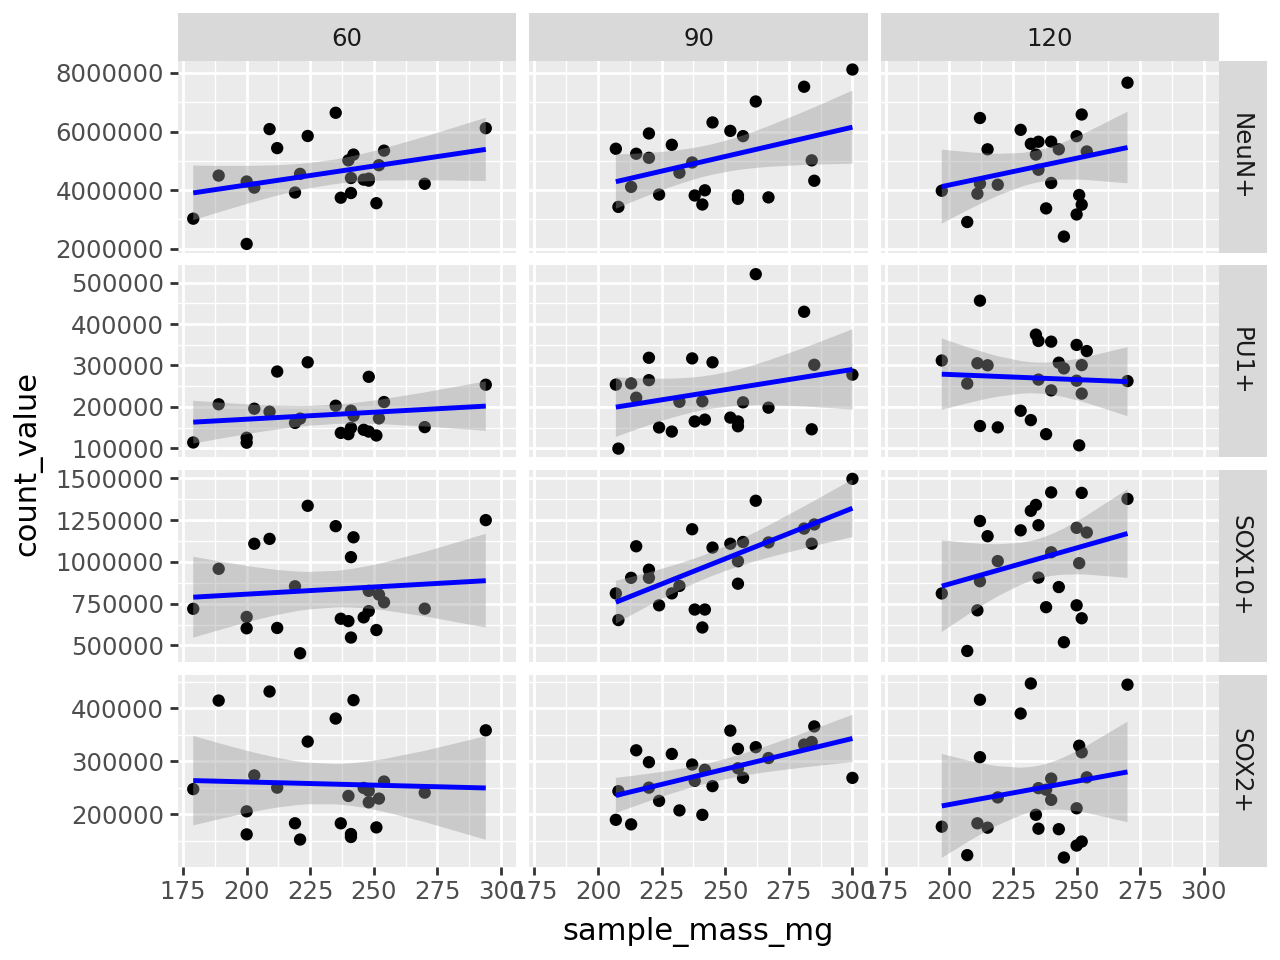

In [66]:
p_mass = (
    ggplot(data=df_raw, mapping=aes(x='sample_mass_mg', y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    # +facet_wrap('population', scales='free_y')
    +facet_grid('population','dpi',scales='free_y')
)
p_mass

In [64]:
df_raw['sample_mass_mg'].describe()

count   288.00
mean    236.75
std      24.18
min     179.00
25%     219.00
50%     239.00
75%     251.25
max     300.00
Name: sample_mass_mg, dtype: float64

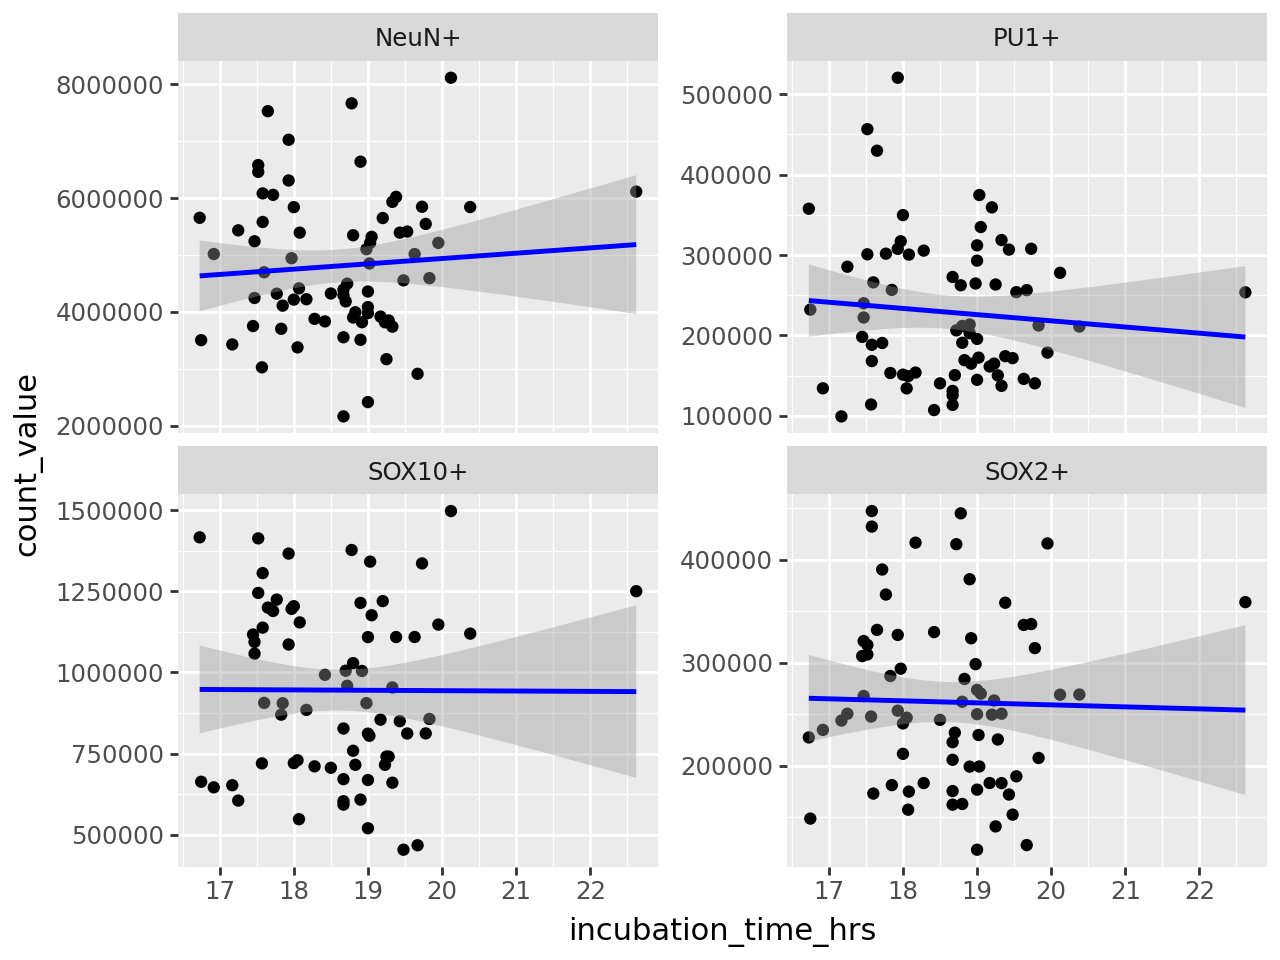

In [60]:
p_inc = (
    ggplot(data=df_raw,
           mapping=aes(x= 'incubation_time_hrs',
                       y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_wrap('population', scales='free_y')
)
p_inc

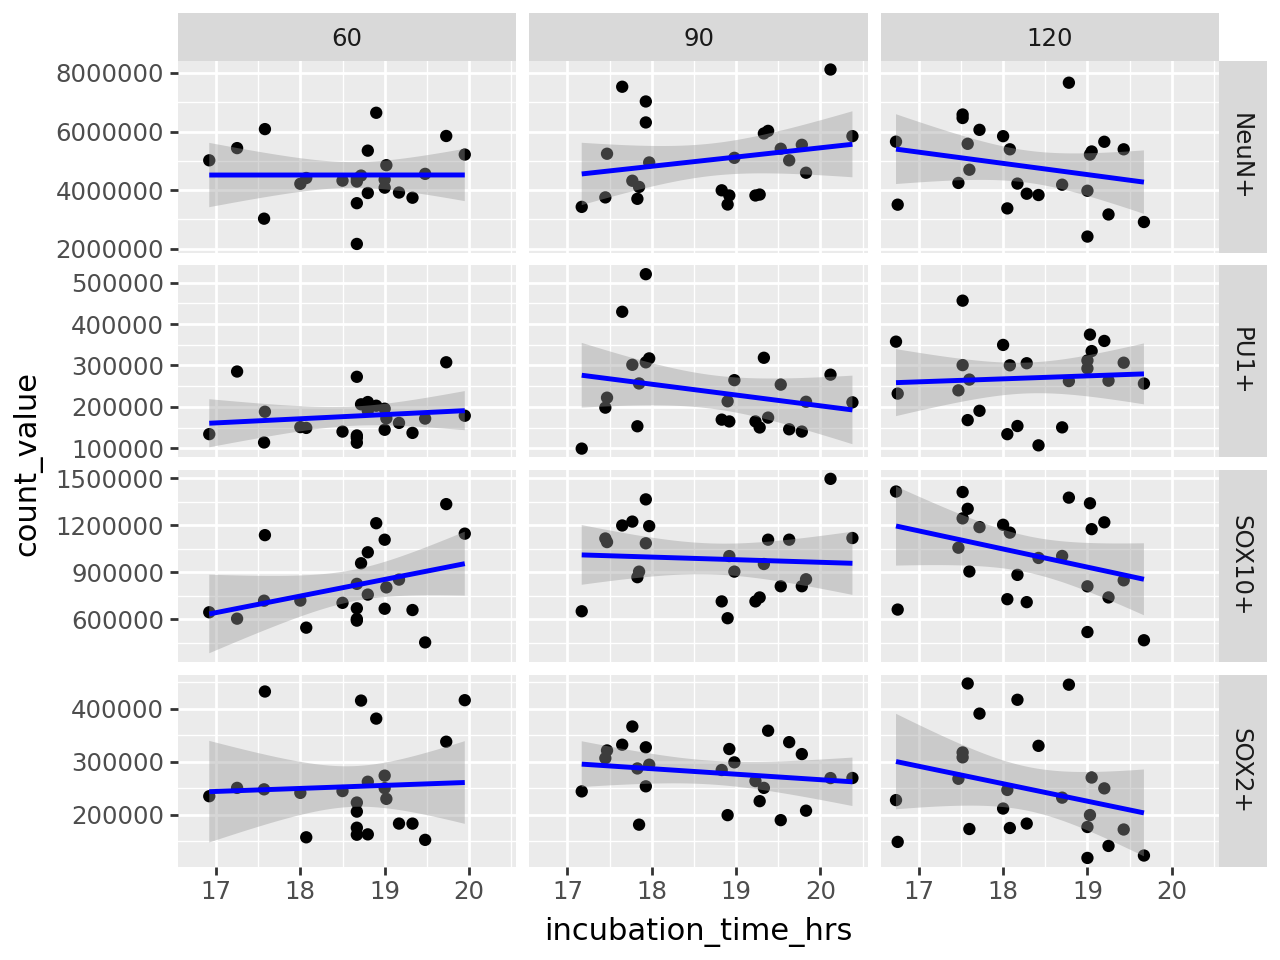

In [55]:
# There is one sample that's a very clear outlier here. 
# remove and replot
df_inc = df_raw[df_raw['incubation_time_hrs'] < 21].copy()
p_inc2 = (
    ggplot(data=df_inc,
           mapping=aes(x= 'incubation_time_hrs',
                       y='count_value')) 
    +geom_point()
    +stat_smooth(method='lm', color='blue')
    +facet_grid('population', 'dpi', scales='free_y')
)
p_inc2

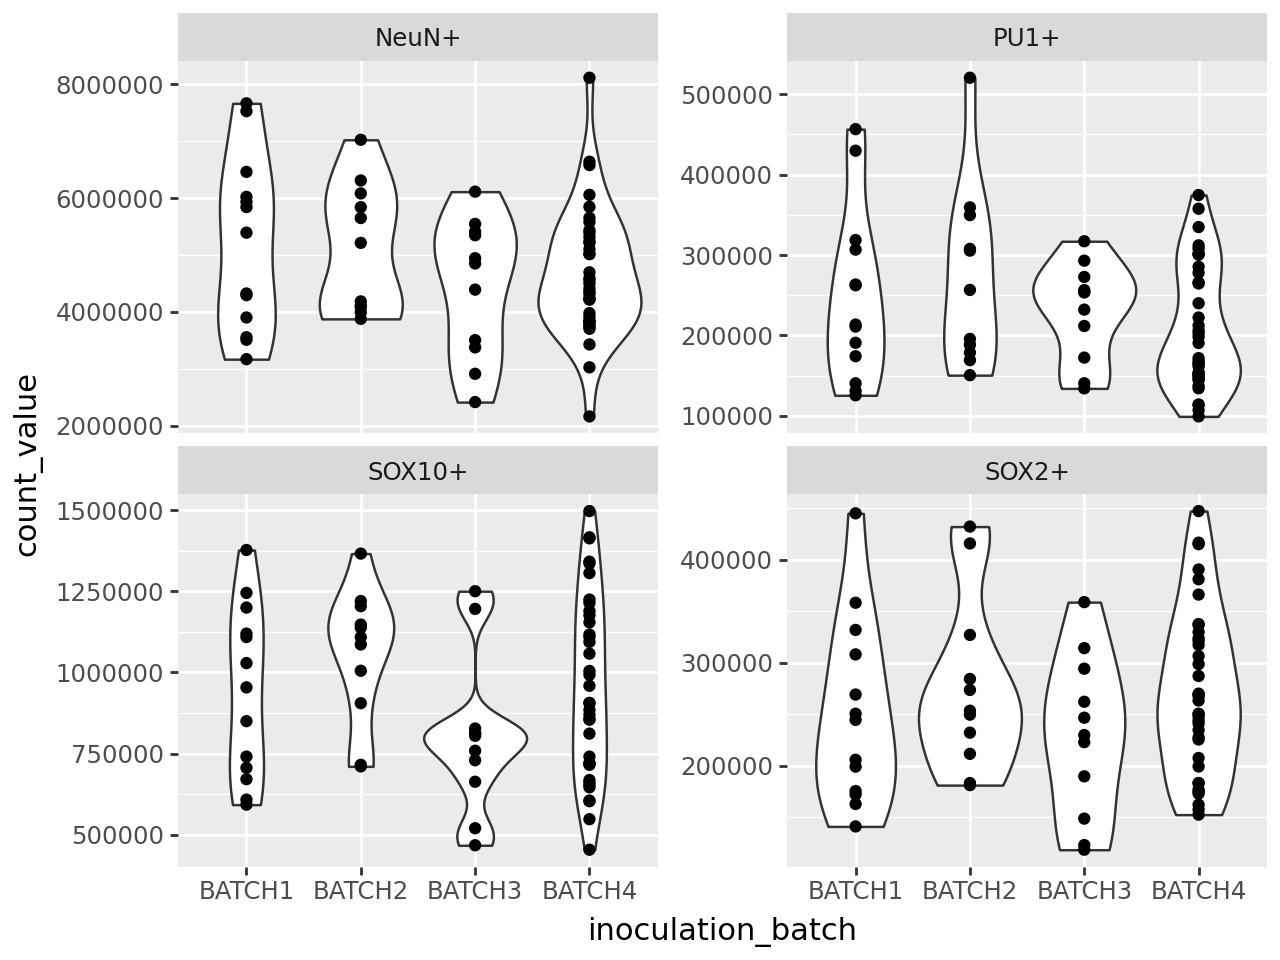

In [61]:
p_batch = (
    ggplot(data=df_raw, mapping=aes(x='inoculation_batch', y='count_value')) 
    +geom_violin()
    +geom_point()
    #+geom_boxplot()
    +facet_wrap('~ population', scales='free_y')
)
p_batch

In [ ]:
geom_point(aes(x='incubation_time', y='nuclei_count'))

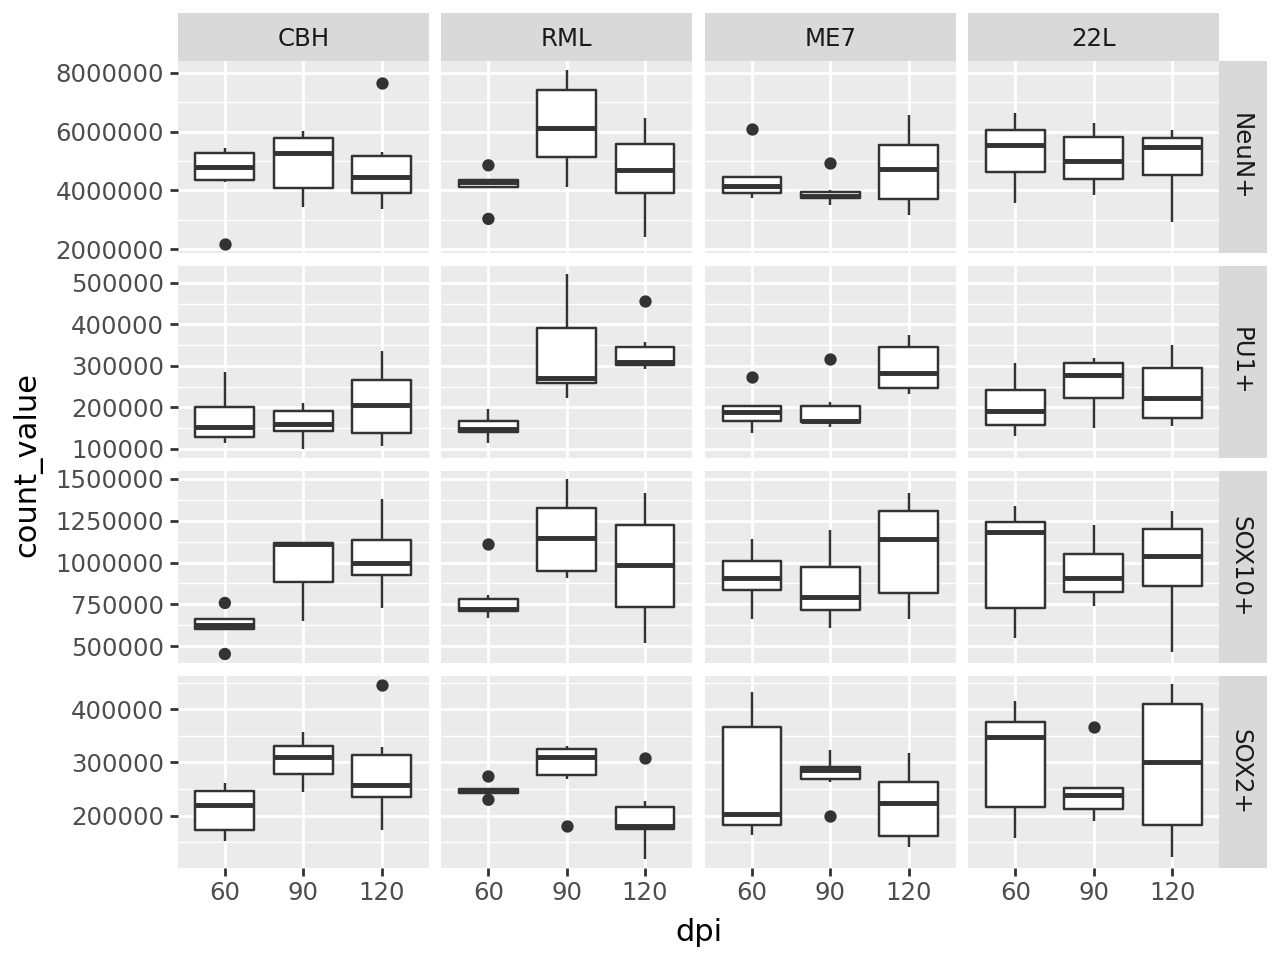

In [17]:
p_box_raw = (
    ggplot(
    data=df_raw,
    mapping=aes(x='dpi', y='count_value')
) 
+ geom_boxplot()
+ facet_grid(rows='population', cols='inoculum', scales="free")
)
p_box_raw

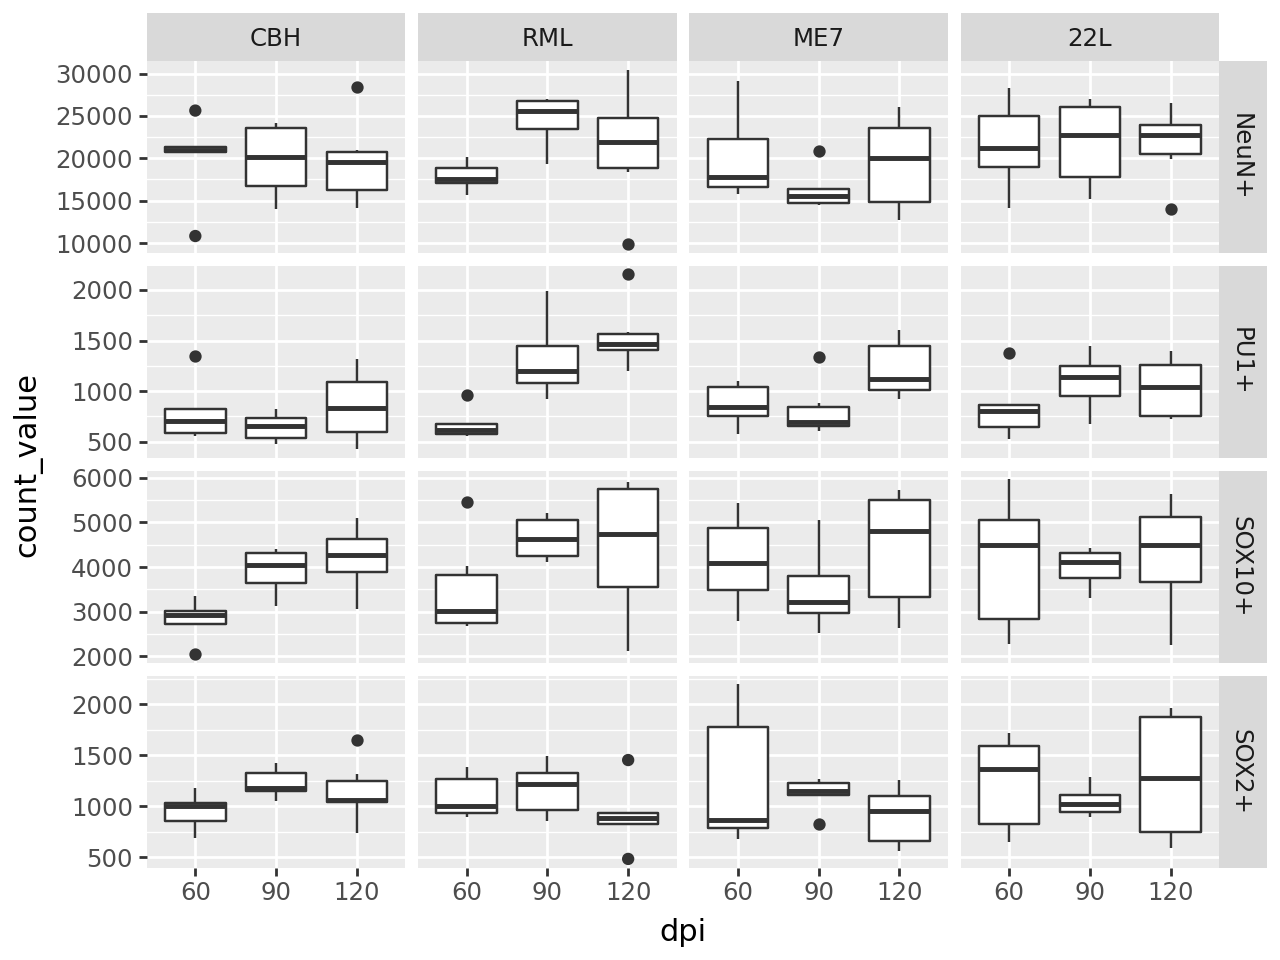

In [16]:
p_box_norm = (
    ggplot(
    data=df_norm,
    mapping=aes(x='dpi', y='count_value')
) 
+ geom_boxplot()
+ facet_grid(rows='population', cols='inoculum', scales="free")

)
p_box_norm